In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patool

     |████████████████████████████████| 77 kB 3.3 MB/s 


In [3]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/gaze360.rar", outdir="/content")

patool: Extracting /content/drive/MyDrive/gaze360.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/gaze360.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/gaze360.rar extracted to `/content'.


'/content'

In [ ]:
from first_part_functions import Kellnhofer_al_eye, Kellnhofer_al_eyes, bulat_al, head_eye_extractors

In [4]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import math
from math import *
from torch.utils.data import Dataset
import torchvision
import torch.optim as optim

source_mat = ''
#=r"C:\Users\108652706\Documents\DOCUMENT_perso\ISI\MLA\trials\gaze360"
mat_fname = pjoin(source_mat, '/content/gaze360/metadata.mat')
mat_contents = sio.loadmat(mat_fname)
sorted(mat_contents.keys())


['__globals__',
 '__header__',
 '__version__',
 'frame',
 'gaze_dir',
 'person_body_bbox',
 'person_cam',
 'person_eye_left_bbox',
 'person_eye_right_bbox',
 'person_eyes2d',
 'person_eyes3d',
 'person_face_bbox',
 'person_head_bbox',
 'person_identity',
 'recording',
 'recordings',
 'split',
 'splits',
 'target_cam',
 'target_pos2d',
 'target_pos3d',
 'ts']

In [ ]:
#name= mat_contents['']

recordings=mat_contents['recordings']
recording = mat_contents['recording']
person_identity= mat_contents['person_identity']
frame= mat_contents['frame']
person_head_bbox = mat_contents['person_head_bbox']
person_eye_left_bbox= mat_contents['person_eye_left_bbox']
cropType= 'head'
person_face_bbox = mat_contents['person_face_bbox']
target_pos3d=mat_contents['target_pos3d']
person_eye_right_bbox= mat_contents['person_eye_right_bbox']
gaze_dir =mat_contents['gaze_dir']

In [ ]:
from torchvision import models 
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from matplotlib import cm
import torch
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip install face_alignment # used as second checker of eye detection in a head image

  Created wheel for face-alignment: filename=face_alignment-1.3.5-py2.py3-none-any.whl size=28239 sha256=143e62c7e8a1293ef5b3d8a5391ffe59bfc922ef629d8a96005706c7731072d3
  Stored in directory: /root/.cache/pip/wheels/c9/ba/4d/2d368f55e5f929f9472da59e356fbdf1483f885de80a5bc620
Successfully built face-alignment


In [ ]:
import face_alignment
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import collections
# Optionally set detector and some additional detector parameters
face_detector = 'sfd'
face_detector_kwargs = {
    "filter_threshold" : 0.8
}

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cuda', flip_input=True,
                                  face_detector=face_detector, face_detector_kwargs=face_detector_kwargs)

Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip" to /root/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/depth-6c4283c0e0.zip" to /root/.cache/torch/hub/checkpoints/depth-6c4283c0e0.zip


  0%|          | 0.00/224M [00:00<?, ?B/s]

In [ ]:
resnet = models.resnet18(pretrained=True)
resnet18 = nn.Sequential(*(list(resnet.children())[:-1])) #take 8 layers 
#resnet18.cpu()
resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

#create functions

In [ ]:
# extract eyes from head image function
def head_eye_extractors(imHead,fa,head_box,target,eye_left_box,eye_right_box):
      if np.all(eye_left_box==np.array([-1,-1,-1,-1])) and np.all(eye_right_box==np.array([-1,-1,-1,-1])):
          #print("eye_not_detected with Kellnhofer_al ")
          imEye_l,imEye_r= bulat_al(imHead,fa)
      else: 
          imEye_l,imEye_r= Kellnhofer_al_eyes(imHead,head_box,eye_left_box,eye_right_box)
      x,y,z=target
      yaw = atan(np.divide(z,x))
      pitch=atan(np.divide(x,y))
      h=[float(yaw),float(pitch)]
      return h, imEye_l,imEye_r

In [ ]:
from torchvision import models 
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from matplotlib import cm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision import datasets
import math
#device = torch.device("cpu")

In [ ]:
from torchvision import models
from torchsummary import summary
summary(resnet18,(3,36,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 30]           9,408
       BatchNorm2d-2           [-1, 64, 18, 30]             128
              ReLU-3           [-1, 64, 18, 30]               0
         MaxPool2d-4            [-1, 64, 9, 15]               0
            Conv2d-5            [-1, 64, 9, 15]          36,864
       BatchNorm2d-6            [-1, 64, 9, 15]             128
              ReLU-7            [-1, 64, 9, 15]               0
            Conv2d-8            [-1, 64, 9, 15]          36,864
       BatchNorm2d-9            [-1, 64, 9, 15]             128
             ReLU-10            [-1, 64, 9, 15]               0
       BasicBlock-11            [-1, 64, 9, 15]               0
           Conv2d-12            [-1, 64, 9, 15]          36,864
      BatchNorm2d-13            [-1, 64, 9, 15]             128
             ReLU-14            [-1, 64

#form datasets

In [ ]:
def dataset ( source_p,nb_image):
    head_imgs=[]
    l_imgs=[]
    r_imgs=[]
    heads=[]
    h_list=[]
    gaze=[]
    for i in range(nb_image): 
          imHead = cv2.imread(os.path.join(
            source_p,
            recordings[0,recording[0,i]][0],
            cropType,
            '%06d' % person_identity[0,i],
            '%06d.jpg' % frame[0,i]
            ))
          heads.append(cv2.resize(imHead,(224,224)))
          h,imEye_l,imEye_r= head_eye_extractors(imHead,fa,person_head_bbox[i,:],target_pos3d[i],person_eye_left_bbox[i,:],person_eye_right_bbox[i,:])
          l_imgs.append(imEye_l)
          r_imgs.append(imEye_r)
          h_list.append(h)
          gaze.append(gaze_dir[i])
    return l_imgs,r_imgs,h_list,heads,gaze



In [ ]:
source_p=('/content/gaze360/imgs') #path to dataset
nb_image= len(frame[0])# number of images
nb_image = 10000 #trial with 20 images only
l_imgs,r_imgs,h,heads,gazes=dataset ( source_p,nb_image)

/usr/local/lib/python3.7/dist-packages/face_alignment/api.py:144: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


In [ ]:
import pickle
# Save 
"""
with open("/content/drive/My Drive/l_imgs.txt", "wb") as fp:   #Pickling
    pickle.dump(l_imgs, fp)

with open("/content/drive/My Drive/r_imgs.txt", "wb") as fp:   #Pickling
    pickle.dump(r_imgs, fp)

with open("/content/drive/My Drive/heads.txt", "wb") as fp:   #Pickling
    pickle.dump(heads, fp)

with open("/content/drive/My Drive/gaze.txt", "wb") as fp:   #Pickling
    pickle.dump(gazes, fp)

with open("/content/drive/My Drive/h_list.txt", "wb") as fp:   #Pickling
    pickle.dump(h, fp)
"""

'\nwith open("/content/drive/My Drive/l_imgs.txt", "wb") as fp:   #Pickling\n    pickle.dump(l_imgs, fp)\n\nwith open("/content/drive/My Drive/r_imgs.txt", "wb") as fp:   #Pickling\n    pickle.dump(r_imgs, fp)\n\nwith open("/content/drive/My Drive/heads.txt", "wb") as fp:   #Pickling\n    pickle.dump(heads, fp)\n\nwith open("/content/drive/My Drive/gaze.txt", "wb") as fp:   #Pickling\n    pickle.dump(gazes, fp)\n\nwith open("/content/drive/My Drive/h_list.txt", "wb") as fp:   #Pickling\n    pickle.dump(h, fp)\n'

In [ ]:
import pickle
# Import 
with open("/content/drive/My Drive/l_imgs.txt", "rb") as fp:   # Unpickling
    l_imgs = pickle.load(fp)

with open("/content/drive/My Drive/r_imgs.txt", "rb") as fp:   # Unpickling
    r_imgs = pickle.load(fp)


with open("/content/drive/My Drive/gaze.txt", "rb") as fp:   # Unpickling
    gazes = pickle.load(fp)



In [ ]:
'''
l_imgs is fl 
r_imgs is fr 
h is (yaw,pich) list 
heads is heads dataset
gazes is (gx,gy,gz) a.k.a target 
'''

## Eye prediction

In [ ]:
class eyeDataset(Dataset):
    """eye landmark dataset."""

    def __init__(self, imgs, transform=None):
       
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #img_name = os.path.join(self.root_dir,self.landmarks_frame.iloc[idx, 0])
        image = self.imgs[idx] #io.imread(img_name)
        image = Image.fromarray(image)
        sample = {'image': image}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

In [ ]:
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [ ]:
(l_imgs[0].shape)

(36, 60, 3)

In [ ]:
l_eye_set=eyeDataset(imgs=l_imgs,transform=preprocess)
l_eye_loader = DataLoader(l_eye_set, batch_size=200,
                        shuffle=False, num_workers=10)
tensor_size = 512 #2048
features_left =torch.zeros((1,tensor_size), dtype=torch.int32, device = 'cuda')

for i in range(len(l_eye_loader)):
    l=next(iter(l_eye_loader))
    outputs_l=l['image'].to(device)
    left=resnet18(outputs_l).flatten(start_dim=1)
    features_left = torch.cat((features_left,left), 0)

features_left=features_left[1:,:]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
features_left.shape

torch.Size([10000, 512])

In [ ]:
# Save 
with open("/content/drive/My Drive/features_left512.txt", "wb") as fp:   #Pickling
    pickle.dump(features_left, fp)

In [ ]:
# Import 
with open("/content/drive/My Drive/features_left512.txt", "rb") as fp:   # Unpickling
    features_left = pickle.load(fp)


In [ ]:
r_eye_set=eyeDataset(imgs=r_imgs,transform=preprocess)
r_eye_loader = DataLoader(r_eye_set, batch_size=200,
                        shuffle=False, num_workers=10)
resnet18.eval()
tensor_size = 512 #2048
features_right =torch.zeros((1,tensor_size), dtype=torch.int32, device = 'cuda')
for i in range(len(r_eye_loader)):
    r=next(iter(r_eye_loader))
    outputs_r=r['image'].to(device)
    right=resnet18(outputs_r).flatten(start_dim=1)# yields a tensor of size([batch_size, 2048])
    features_right = torch.cat((features_right,right), 0)

features_right=features_right[1:,:]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# save
with open("/content/drive/My Drive/features_right512.txt", "wb") as fp:   #Pickling
    pickle.dump(features_right, fp)

In [ ]:
# load
with open("/content/drive/My Drive/features_right512.txt", "rb") as fp:   # Unpickling
    features_right = pickle.load(fp)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
features_right.shape

torch.Size([10000, 512])

In [ ]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(resnet18.to(device),input_size=(3, 36, 60))# summary works only with gpu,so we change model to gpu then take it back to cpu


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 30]           9,408
       BatchNorm2d-2           [-1, 64, 18, 30]             128
              ReLU-3           [-1, 64, 18, 30]               0
         MaxPool2d-4            [-1, 64, 9, 15]               0
            Conv2d-5            [-1, 64, 9, 15]          36,864
       BatchNorm2d-6            [-1, 64, 9, 15]             128
              ReLU-7            [-1, 64, 9, 15]               0
            Conv2d-8            [-1, 64, 9, 15]          36,864
       BatchNorm2d-9            [-1, 64, 9, 15]             128
             ReLU-10            [-1, 64, 9, 15]               0
       BasicBlock-11            [-1, 64, 9, 15]               0
           Conv2d-12            [-1, 64, 9, 15]          36,864
      BatchNorm2d-13            [-1, 64, 9, 15]             128
             ReLU-14            [-1, 64

##Head pose

In [ ]:
import pickle

with open("/content/drive/My Drive/h_list.txt", "rb") as fp:   # Unpickling
    h = pickle.load(fp)

import pickle
with open("/content/drive/My Drive/heads.txt", "rb") as fp:   # Unpickling
    heads = pickle.load(fp)

In [ ]:

class headposeDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, imgs, h, transform=None):
        self.h = h
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.imgs[idx] 
        image = Image.fromarray(image)
        ex = self.h[idx]
        '''
        landmarks = np.zeros(2)
        landmarks=np.zeros(2)
        landmarks[0]= ex[0]
        landmarks[1]= ex[1]
        '''
        landmarks = np.array(ex)
        if self.transform:
            image = self.transform(image)
        #sample = {'image': image, 'landmarks': landmarks}
        sample = {'image': image, 'landmarks': landmarks}

        return sample

In [ ]:
#select number of elements for training
h = h[:5000]
heads = heads [:5000]

In [ ]:
len(heads)

5000

In [ ]:
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.double()),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
face_pose_dataset = headposeDataset(imgs=heads,h=h,transform=preprocess)
#dataloader = DataLoader(face_pose_dataset, batch_size=32,shuffle=True, num_workers=0)


In [ ]:
validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size= 128 #32

# Creating data indices for training and validation splits:
dataset_size = len(face_pose_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(face_pose_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(face_pose_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [ ]:
#Function to create a Pretrained Resnet Model with a Fully Connected Layer
# (out_1: ouput of 1st layer), (out_2: ouput of 2nd layer)
def createModel_resnet34(out_1, out_2):
    model = torchvision.models.resnet34(pretrained = True)
    num_ftrs = model.fc.in_features

    for param in model.parameters():
        param.requires_grad = False
    
    #Creating 3 Linear connected layers which can be trained
    fc1 = nn.Linear(num_ftrs, out_1)
    fc2 = nn.Linear(out_1, out_2)
    fc3 = nn.Linear(out_2, 2)

    layers = [fc1, fc2, fc3]
    for linearLayer in layers:
        #Applying He initialization to all layers
        nn.init.kaiming_uniform_(linearLayer.weight, nonlinearity='leaky_relu')
  


    #Setting Resnet's fully connected layer to our collection of three Linear layers with nn.Sequential
    model.fc = nn.Sequential(fc1, nn.LeakyReLU(),fc2, nn.LeakyReLU(),fc3)
    model.double() #double to set variables to double
    #Sending the device to the GPU if avaliable
    model.to(device)

    return model

In [ ]:
#check types : make sure both types are the same
print(next(iter(train_loader))['image'].type())
print(next(iter(train_loader))['landmarks'].type())


torch.DoubleTensor
torch.DoubleTensor


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Starting training
Epoch Number: 0
loss: 39.124194716293246
val loss: 0.3790560671055705
Epoch Number: 1
loss: 1.1366954985012385
val loss: 0.21022752110276346
Epoch Number: 2
loss: 0.6803108199023014
val loss: 0.1551432535655774
Epoch Number: 3
loss: 0.5280079733886046
val loss: 0.12293617984425104
Epoch Number: 4
loss: 0.42880822821164893
val loss: 0.10548899839910379
Epoch Number: 5
loss: 0.35170648266660204
val loss: 0.08852488983904284
Epoch Number: 6
loss: 0.2959119817659949
val loss: 0.07648585276597716
Epoch Number: 7
loss: 0.25492010206246096
val loss: 0.06629176323817079
Epoch Number: 8
loss: 0.22220617983534005
val loss: 0.058138166136445436
Epoch Number: 9
loss: 0.19092529317693546
val loss: 0.05318133111350291
Epoch Number: 10
loss: 0.16916631210111902
val loss: 0.046932979585186975
Epoch Number: 11
loss: 0.154416587016557
val loss: 0.042947003858372454
Epoch Number: 12
loss: 0.13742679066209607
val loss: 0.03931561309981034
Epoch Number: 13
loss: 0.12381318591629895
val lo

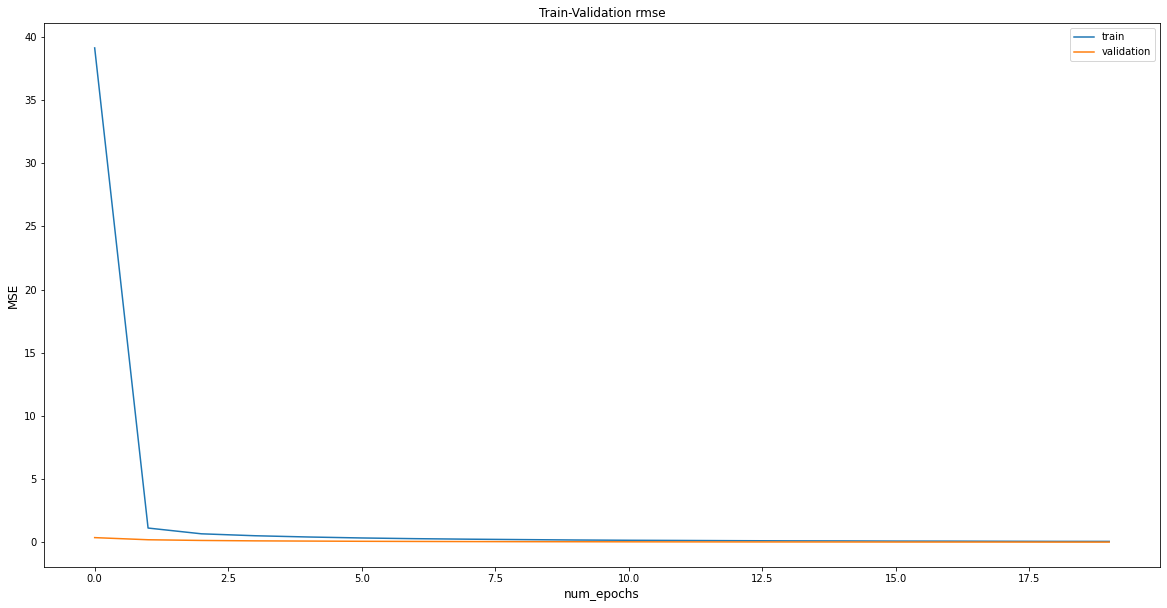

In [ ]:
#Function to handle training
#(model: model to train), (criterion: loss function for the model), (optimizer, what optimizer to use)
def train(model, criterion, optimizer, file, epochs=20, trainLoss=[], validationLoss=[]):
    #device = torch.device("cpu")
    print("Starting training")
    for epoch in range(epochs):
        print(f"Epoch Number: {epoch}")

        testAccuracy = 0
        totalLoss = 0

        #for i,data in range(len(train_loader)):
        for i,batch in enumerate(train_loader):
            #Put model into training mode
            model.train()
            #batch= next(iter(train_loader))
            x=batch['image'].to(device)
            y=batch['landmarks'].to(device)
            #Zero out gradients
            optimizer.zero_grad()
            #Make a prediction
            y_hat = model(x)
            
            #Calculate the loss
            loss = criterion(y_hat, y)
            #l = torch.sqrt(loss)
            #Update the total loss
            totalLoss += loss
            #Initiate backpropagation
            loss.backward()
            
            #Update parameters
            optimizer.step()

            #testAccuracy += (y_hat == y).sum().item()
        trainLoss.append(totalLoss)
        print(f"loss: {totalLoss}")
        
        valAccuracy = 0
        totalLoss = 0
        
        for j,banch in enumerate(validation_loader):
        #for j in range(len(validation_loader)):
            # Put the model into evaluation mode
            #banch= next(iter(validation_loader))
            x=banch['image'].to(device)
            y=banch['landmarks'].to(device)
            model.eval()
            y_pred= model(x)
            #print(y_pred)
            loss = criterion(y_pred, y)
            #l = torch.sqrt(loss)
            totalLoss += loss
        print(f"val loss: {totalLoss}")
        validationLoss.append(totalLoss)
        #Save our model for each epoch
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation rmse")
    plt.plot(trainLoss, label='train')
    plt.plot(validationLoss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('MSE', fontsize=12)
    plt.legend(loc='best')
    plt.savefig('head_pose_extractor_RMSE.png')
    plt.savefig( "/content/drive/MyDrive/"+'head_pose_extractor_MSE.png')

    torch.save(model.state_dict(), file)
    torch.save(model.state_dict(), "/content/drive/MyDrive/"+file)
    return trainLoss, validationLoss, model

#Create a model using our function
model = createModel_resnet34(512, 128)
#Define our loss and optimizers
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(),lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#Specify output file name
file = "head_pose_extractor.pth" #save model

#Try to use Colab's GPU here, otherwise it will take a long time to train.
output = train(model, criterion, optimizer, file)

In [ ]:
with open('/content/gdrive/My Drive/heads.txt', 'w') as f:
  heads.write('content')

In [ ]:
%reset # to reset all variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
